In [6]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import progressbar
from scipy import stats
sns.set()

%matplotlib inline

# Define path and load files 

Accross the analysis the following names are used for the 3 screens
- ova == Ovariole Number screen
- fec == Hippo RNAi EggLaying screen
- xRNAi == EggLaying screen

In [7]:
data = "../Data"
resultpath = '../Results/'
PPI_ID = "2018_08"

In [8]:
G = nx.read_graphml(os.path.join(data, 'PPIs', 'PPI_{}.graphml'.format(PPI_ID)))
hipo_ova = pd.read_csv(os.path.join(data,'Screen','hipo_ova_clean.csv'))
xRNAi_fec = pd.read_csv(os.path.join(data,'Screen','xRNAi_fec_clean.csv'))
hipo_fec = pd.read_csv(os.path.join(data,'Screen','hipo_fec_clean.csv'))
signaling = pd.read_csv(os.path.join(data,'signaling.csv'))

In [9]:
# We only consider the sum of eggs layed over 5 days, so we restrict the data to the "Sum"
xRNAi_fec = xRNAi_fec[xRNAi_fec['Condition'] == 'Sum'].reset_index(drop=True)
hipo_fec = hipo_fec[hipo_fec['Condition'] == 'Sum'].reset_index(drop=True)

In [10]:
# Modules computed in the notebook file: Seed-Connector
ova_module_G = nx.read_graphml(os.path.join(resultpath,'Ova_module_{}.graphml'.format(PPI_ID)))
fec_module_G = nx.read_graphml(os.path.join(resultpath,'Hpo_EggL_module_{}.graphml'.format(PPI_ID)))
xRNAi_module_G = nx.read_graphml(os.path.join(resultpath,'EggL_module_{}.graphml'.format(PPI_ID)))
core_module_G = nx.read_graphml(os.path.join(resultpath,'Core_module_{}.graphml'.format(PPI_ID)))

# Prepare groups of genes and positive candidate set
Here we calculate the mean of the Zscore for each gene in the screens, define thresholds for significance, and create subsets of genes

In [11]:
mean_ova_gene = hipo_ova.groupby('FbID', as_index=False).mean()
mean_fec_gene = hipo_fec.groupby('FbID', as_index=False).mean()
mean_xRNAi_gene = xRNAi_fec.groupby('FbID', as_index=False).mean()

In [12]:
len([i for i in mean_ova_gene['FbID'].unique() if 'FBgn' in i])

273

In [13]:
ova_module = ova_module_G.nodes()
fec_module = fec_module_G.nodes()
xRNAi_module = xRNAi_module_G.nodes()
core_module = core_module_G.nodes()

In [14]:
# Here we select all the genes that were tested in the screen,
# because the first screen was Hipo RNAi EggLaying measurement, this dataset contains all the tested genes
screen_genes = mean_fec_gene['FbID'].values
ScreenG = G.subgraph(screen_genes)

In [15]:
# We redefine our threshold of 2 and 5 for Z score cutoff
ova_threshold = 2
eggl_threshold = 5

In [16]:
# Ovariole number screen
# Keep only genes with a Zscore over or equal to 2
ova_seed = mean_ova_gene[(mean_ova_gene['Z'].abs()>=ova_threshold)]['FbID'].values
# Filter out the controls
ova_seed = [i for i in ova_seed if 'FBgn' in i]

# Hippo RNAi Egg Laying screen
# Keep only genes with a Zscore over or equal to 5
fec_seed = mean_fec_gene[(mean_fec_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
fec_seed = [i for i in fec_seed if 'FBgn' in i]

# Egg Laying Screen
# Keep only genes with a Zscore over or equal to 5
xRNAi_seed = mean_xRNAi_gene[(mean_xRNAi_gene['Z'].abs()>=eggl_threshold)]['FbID'].values
# Filter out the controls
xRNAi_seed = [i for i in xRNAi_seed if 'FBgn' in i]

core_seed = set.intersection(set(ova_seed), set(fec_seed), set(xRNAi_seed))

# Define helper functions

In [18]:
def LCCbootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    LCC = len(max(nx.connected_components(subG), key=len))
    print('LCC:', LCC)
    
    # Starting BootStrap
    random_LCCs = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_cc = max(nx.connected_components(randomG), key=len)
        random_LCCs.append(len(random_cc))
    return random_LCCs, LCC

def Edgebootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    edges = len(subG.edges())
    print('edges:', edges)
    
    # Starting BootStrap
    random_edges = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_edges.append(len(randomG.edges()))
    return random_edges, edges

def Densitybootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    density = nx.density(subG)
    print('density:', density)
    
    # Starting BootStrap
    random_density = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_density.append(nx.density(randomG))
    return random_density, density

def AverageShortestPathbootsrap(G, ScreenG, seeds, bootstrapnb=10000):
    subG = G.subgraph(seeds)
    print('Percent found in the PPI:', len(subG.nodes()) / len(seeds))
    print('Graph Size:',len(subG))
    avg = nx.average_shortest_path_length(max(nx.connected_component_subgraphs(subG), key=len))
    print('AverageShortestPath:', avg)
    
    # Starting BootStrap
    random_avg = []
    for i in progressbar.progressbar(range(bootstrapnb)):
        random_nodes = np.random.choice(ScreenG.nodes(), len(subG), replace=False)
        randomG = ScreenG.subgraph(random_nodes)
        random_avg.append(nx.average_shortest_path_length(max(nx.connected_component_subgraphs(randomG), key=len)))
    return random_avg, avg

def plotNetworkTests(G,ScreenG, seeds, module=None, bootstrapnb=10000, bw=1, full=False):
    random_LCC, LCC = LCCbootsrap(G, ScreenG, seeds, bootstrapnb)
    random_edges, edges = Edgebootsrap(G, ScreenG, seeds, bootstrapnb)
    if full:
        random_density, density = Densitybootsrap(G, ScreenG, seeds, bootstrapnb)
        random_avg, avg = AverageShortestPathbootsrap(G, ScreenG, seeds, bootstrapnb)
    if module:
        random_LCC_module, LCC_module = LCCbootsrap(G, ScreenG, module, bootstrapnb)
        random_Edge_module, Edge_module = Edgebootsrap(G, ScreenG, module, bootstrapnb)
        if full:
            random_density_module, density_module = Densitybootsrap(G, ScreenG, module, bootstrapnb)
            random_avg_module, avg_module = AverageShortestPathbootsrap(G, ScreenG, module, bootstrapnb)

    if full:
        fig = plt.figure(figsize=(5,5))
        row = 2
        col = 2
    else:
        fig = plt.figure(figsize=(7,5))
        row = 1
        col = 2
    
    ax = fig.add_subplot(row, col, 1)
    
    sns.kdeplot(random_LCC, bw=np.std(random_LCC), shade=True, color='lightgray', label="Random bootstrap (PPI)")
    bot, top = ax.get_ylim()
    plt.plot([LCC,LCC], [0,top], 'lightcoral', label='Seed Genes (PPI)')
    if module:
        sns.kdeplot(random_LCC_module, bw=np.std(random_LCC_module), shade=True, color='gray', label="Random bootstrap (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([LCC_module,LCC_module], [0,top], 'darkred', label='Network Module (PPI)')

    plt.title('Largest Connected Component of\nselected genes VS random')
    ax.legend().set_visible(False)
    plt.xlabel('LCC')
    plt.ylabel('Probability Density')
    plt.xlim(0)
    
    ax = fig.add_subplot(row, col, 2)
    sns.kdeplot(random_edges, bw=np.std(random_edges), shade=True, color='lightgray', label="Random bootstrap seed (PPI)")
    bot, top = ax.get_ylim()
    plt.plot([edges,edges], [0,top], 'lightcoral', label='Seed Genes (PPI)')
    if module:
        sns.kdeplot(random_Edge_module, bw=np.std(random_Edge_module), shade=True, color='gray', label="Random bootstrap module (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([Edge_module,Edge_module], [0,top], 'darkred', label='Network Module (PPI)')

    plt.title('Number of interactions of\nselected genes VS random')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Number of Interactions')
    plt.xlim(0)
    
    if full:
        ax = fig.add_subplot(row, col, 3)
        sns.kdeplot(random_density, bw=np.std(random_density), shade=True, color='lightgray', label="Random bootstrap seed (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([density,density], [0,top], 'lightcoral', label='Seed Genes (PPI)')
        if module:
            sns.kdeplot(random_density_module, bw=np.std(random_density_module), shade=True, color='gray', label="Random bootstrap module (PPI)")
            bot, top = ax.get_ylim()
            plt.plot([density_module,density_module], [0,top], 'darkred', label='Network Module (PPI)')

        plt.title('Network density of\nselected genes VS random')
        ax.legend().set_visible(False)
        plt.xlabel('Network density')
        plt.xlim(0)
        
        ax = fig.add_subplot(row, col, 4)
        sns.kdeplot(random_avg, bw=np.std(random_avg), shade=True, color='lightgray', label="Random bootstrap seed (PPI)")
        bot, top = ax.get_ylim()
        plt.plot([avg,avg], [0,top], 'lightcoral', label='Seed Genes (PPI)')
        if module:
            sns.kdeplot(random_avg_module, bw=np.std(random_avg_module), shade=True, color='gray', label="Random bootstrap module (PPI)")
            bot, top = ax.get_ylim()
            plt.plot([avg_module,avg_module], [0,top], 'darkred', label='Network Module (PPI)')

        plt.title('Average shortest path of LCC of\nselected genes VS random')
        ax.legend().set_visible(False)
        plt.xlabel('Average shortest path of LCC')
        plt.xlim(0)        
       
    return fig

# Let's look at the modules and seeds conectivity in the network
This assess whether there is a Network Effect in the group of gene studied. 
It could be seen as an Enrichment test. 
## First I want to make sure that the Screen Genes are not already more connected than random.

In [19]:
# Choose a bootstrap number to run the anlaysis with
bootstrap = 1000

  0% (4 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:29

Percent found in the PPI: 0.9482758620689655
Graph Size: 440
LCC: 381


100% (1000 of 1000) |####################| Elapsed Time: 0:00:19 Time:  0:00:19
  0% (8 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:14

Percent found in the PPI: 0.9482758620689655
Graph Size: 440
edges: 1286


100% (1000 of 1000) |####################| Elapsed Time: 0:00:21 Time:  0:00:21
  0% (6 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:17

Percent found in the PPI: 0.9482758620689655
Graph Size: 440
density: 0.013315386208324705


100% (1000 of 1000) |####################| Elapsed Time: 0:00:24 Time:  0:00:24


Percent found in the PPI: 0.9482758620689655
Graph Size: 440


  0% (2 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:01:12

AverageShortestPath: 3.4752175714877747


100% (1000 of 1000) |####################| Elapsed Time: 0:02:09 Time:  0:02:09


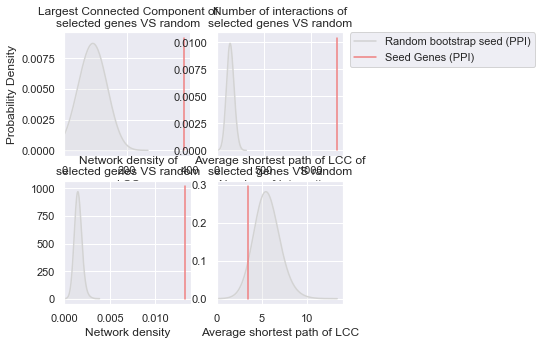

In [20]:
title = "ScreenBackground"
fig = plotNetworkTests(G, G, screen_genes, bootstrapnb=bootstrap, full=True)
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

We can see a non negligible network module effect of the signaling genes ... Therefore, we will analyze the modules with this set as a background instead of the whole PPI.

## Network effect of the Ovariole numbers regulators 

  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
LCC: 40


100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:03

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
edges: 54


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  1% (12 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:08

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
density: 0.025174825174825177


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (7 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:18

Percent found in the PPI: 0.9850746268656716
Graph Size: 66
AverageShortestPath: 4.7474358974358974


100% (1000 of 1000) |####################| Elapsed Time: 0:00:16 Time:  0:00:16
  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Percent found in the PPI: 1.0
Graph Size: 77
LCC: 74


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  1% (13 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 1.0
Graph Size: 77
edges: 106


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:05

Percent found in the PPI: 1.0
Graph Size: 77
density: 0.036226930963773066


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  0% (8 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:14

Percent found in the PPI: 1.0
Graph Size: 77
AverageShortestPath: 4.155127730470197


100% (1000 of 1000) |####################| Elapsed Time: 0:00:18 Time:  0:00:18


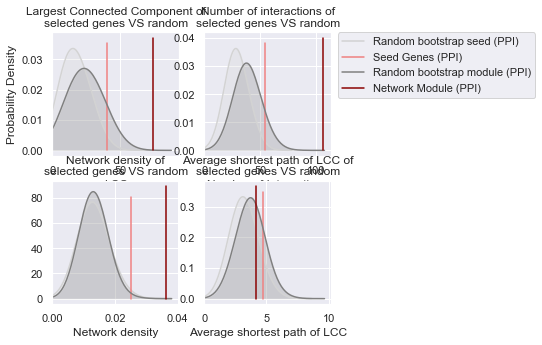

In [21]:
fig = plotNetworkTests(G, ScreenG, ova_seed, ova_module, bootstrapnb=bootstrap, full=True)
title = "OvarioleModule"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The ovariole regulators for a module within the background set of screened genes

## Network effect of the EggLaying regulators under Hippo RNAi 

  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 0.9830508474576272
Graph Size: 58
LCC: 21


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:03

Percent found in the PPI: 0.9830508474576272
Graph Size: 58
edges: 31


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  1% (11 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:09

Percent found in the PPI: 0.9830508474576272
Graph Size: 58
density: 0.018753781004234724


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  1% (10 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:10

Percent found in the PPI: 0.9830508474576272
Graph Size: 58
AverageShortestPath: 3.8


100% (1000 of 1000) |####################| Elapsed Time: 0:00:16 Time:  0:00:16
  1% (12 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:08

Percent found in the PPI: 1.0
Graph Size: 76
LCC: 74


100% (1000 of 1000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08
  1% (11 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:10

Percent found in the PPI: 1.0
Graph Size: 76
edges: 82


100% (1000 of 1000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08
  1% (12 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:08

Percent found in the PPI: 1.0
Graph Size: 76
density: 0.028771929824561403


100% (1000 of 1000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09
  0% (6 of 1000) |                       | Elapsed Time: 0:00:00 ETA:   0:00:16

Percent found in the PPI: 1.0
Graph Size: 76
AverageShortestPath: 5.188078489448352


100% (1000 of 1000) |####################| Elapsed Time: 0:00:19 Time:  0:00:19


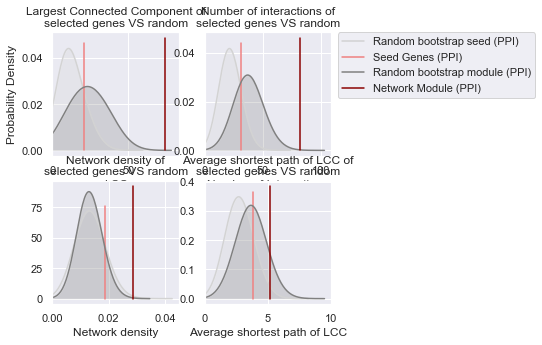

In [22]:
fig = plotNetworkTests(G, ScreenG, fec_seed, fec_module, bootstrapnb=bootstrap, full=True)
title = "HpoRNAiEggL"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The effect is less strong for the seed genes, but once the module is established, there exist a clear network module 

## Network effect of the EggLaying regulators

  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 49
LCC: 22


100% (1000 of 1000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 1.0
Graph Size: 49
edges: 28


100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Percent found in the PPI: 1.0
Graph Size: 49
density: 0.023809523809523808


100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  1% (13 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:08

Percent found in the PPI: 1.0
Graph Size: 49
AverageShortestPath: 4.476190476190476


100% (1000 of 1000) |####################| Elapsed Time: 0:00:12 Time:  0:00:12
  1% (13 of 1000) |                      | Elapsed Time: 0:00:00 ETA:  00:00:00

Percent found in the PPI: 1.0
Graph Size: 60
LCC: 56


100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:05

Percent found in the PPI: 1.0
Graph Size: 60
edges: 64


100% (1000 of 1000) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 1.0
Graph Size: 60
density: 0.03615819209039548


100% (1000 of 1000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
  1% (13 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 1.0
Graph Size: 60
AverageShortestPath: 5.096103896103896


100% (1000 of 1000) |####################| Elapsed Time: 0:00:15 Time:  0:00:15


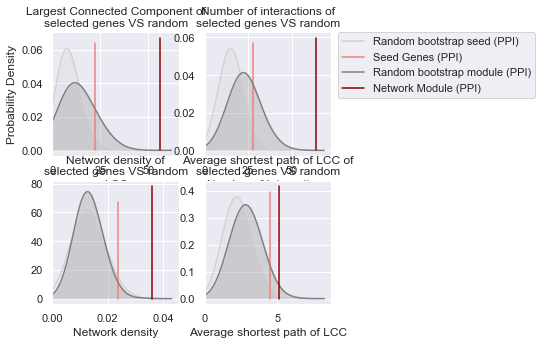

In [23]:
fig = plotNetworkTests(G, ScreenG, xRNAi_seed, xRNAi_module, bootstrapnb=bootstrap, full=True)
title = "EggL"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The EggLaying regulator with no background have a similar effect than the EggLaying Hippo RNAi. The effect of the seed genes is not as strong, however, once the module is established, there is a strong significant connectivity between the genes.

## Network effect of the core module

  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:03

Percent found in the PPI: 1.0
Graph Size: 27
LCC: 7


100% (1000 of 1000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:05

Percent found in the PPI: 1.0
Graph Size: 27
edges: 10


100% (1000 of 1000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:03

Percent found in the PPI: 1.0
Graph Size: 27
density: 0.02849002849002849


100% (1000 of 1000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Percent found in the PPI: 1.0
Graph Size: 27
AverageShortestPath: 2.1904761904761907


100% (1000 of 1000) |####################| Elapsed Time: 0:00:05 Time:  0:00:05
  3% (38 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:03

Percent found in the PPI: 1.0
Graph Size: 37
LCC: 36


100% (1000 of 1000) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
  5% (51 of 1000) |#                     | Elapsed Time: 0:00:00 ETA:   0:00:02

Percent found in the PPI: 1.0
Graph Size: 37
edges: 50


100% (1000 of 1000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
  3% (32 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:05

Percent found in the PPI: 1.0
Graph Size: 37
density: 0.07507507507507508


100% (1000 of 1000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04
  2% (26 of 1000) |                      | Elapsed Time: 0:00:00 ETA:   0:00:07

Percent found in the PPI: 1.0
Graph Size: 37
AverageShortestPath: 3.3095238095238093


100% (1000 of 1000) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


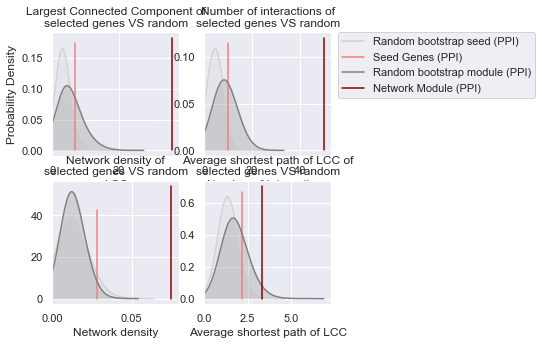

In [24]:
fig = plotNetworkTests(G, ScreenG, core_seed, core_module, bootstrapnb=bootstrap, full=True)
title = "CoreModule"
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.svg'.format(title)))
fig.savefig(os.path.join(resultpath, 'Figures/NetworkStatistics/{}.png'.format(title)))

The core module has an in between effect, where the seeds are fairly enriched, though within random. But the the module is highly enriched. 